## 콘텐츠 기반 추천 시스템을 위한 데이터 분석

In [1]:
# library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import missingno as msno
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

from sklearn.model_selection import train_test_split , cross_val_score , StratifiedKFold
from sklearn.preprocessing import LabelEncoder , RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# 폰트 설정

font_path = 'C:/Windows/Fonts/MALGUNSL.TTF'
font_name = fm.FontProperties(fname = font_path).get_name()
plt.rc('font' , family = font_name)

In [2]:
# data import

path = "C:/Users/user/Desktop/K-Digital Project 002/K_Digital_02/kkh3363/분석 자료/개발자2/New_Data/"
data = pd.read_csv(path + 'merged_orig_data_drop_duplicates.csv')
orig_data = pd.read_csv(path + 'merged_orig_data_drop_duplicates.csv')
metadata = pd.read_excel(path + "인기대출_컬럼정의서.xls")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25075 entries, 0 to 25074
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SEQ_NO             25075 non-null  int64  
 1   RANK_CO            25075 non-null  int64  
 2   INPT_DE            25075 non-null  object 
 3   ISBN_THIRTEEN_NO   25075 non-null  int64  
 4   BOOK_TITLE_NM      25075 non-null  object 
 5   AUTHR_NM           25049 non-null  object 
 6   BOOK_INTRCN_CN     23919 non-null  object 
 7   PUBLISHER_NM       25064 non-null  object 
 8   PBLICTE_DE         25073 non-null  object 
 9   BOOK_IMAGE_NM      25074 non-null  object 
 10  BOOK_MASTR_SEQ_NO  25075 non-null  int64  
 11  KDC_NM             18675 non-null  float64
 12  LON_CO             25075 non-null  int64  
 13  ANALS_PD_CD        25075 non-null  object 
 14  ANALS_PD_CD_NM     25075 non-null  object 
 15  ANALS_TY_CD        25075 non-null  int64  
 16  ANALS_TY_CD_NM     250

In [4]:
metadata

,순서,컬럼영문명,컬럼한글명,데이터타입,길이,PK여부,NOT NULL여부
0,1,SEQ_NO,일련번호,int,11.0,Y,Y
1,2,RANK_CO,순위수,int,1.0,N,N
2,3,INPT_DE,입력일자,varchar,10.0,N,N
3,4,ISBN_THIRTEEN_NO,ISBN13번호,varchar,13.0,N,N
4,5,BOOK_TITLE_NM,서적제목명,varchar,300.0,N,N
5,6,AUTHR_NM,저작자명,varchar,300.0,N,N
6,7,BOOK_INTRCN_CN,서적소개내용,text,NaN,N,N
7,8,PUBLISHER_NM,출판사명,varchar,100.0,N,N
8,9,PBLICTE_DE,발행일자,varchar,10.0,N,N
9,10,BOOK_IMAGE_NM,서적이미지명,varchar,500.0,N,N


### 원천 데이터 중에서 적은 건수의 데이터 판별

,LON_CO
count,25075.000000
mean,18.315454
std,67.577758
min,1.000000
25%,2.000000
50%,4.000000
75%,12.000000
max,1142.000000


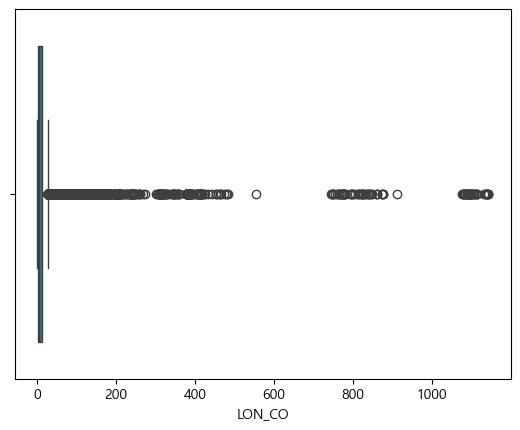

In [5]:
check = data[['LON_CO']]

sns.boxplot(
    data = check ,
    x = 'LON_CO'
)

check.describe()

In [6]:
# 3 이하를 배제

print(f"비율 : {round(len(data[data['LON_CO'] <= 3]) / len(data) * 100 , 2)}%")
print(f"3이하를 분리할 경우 : {len(data)} -> {len(data) - len(data[data['LON_CO'] <= 3])}")
data = data[data['LON_CO'] > 3]

비율 : 45.68%
3이하를 분리할 경우 : 25075 -> 13621


In [7]:
# feature selection

"""
RANK_CO , INPT_DE , PBLICTE_DE , KDC_NM , LON_CO , AGE_FLAG_NM , SEXDSTN_FLAG_NM
"""
data.iloc[:3 , 0:10]

,SEQ_NO,RANK_CO,INPT_DE,ISBN_THIRTEEN_NO,BOOK_TITLE_NM,AUTHR_NM,BOOK_INTRCN_CN,PUBLISHER_NM,PBLICTE_DE,BOOK_IMAGE_NM
0,263404341,869,2021-03-16,9788972915782,군주론,저자: 니콜로 마키아벨리 ;김경희,마키아벨리 전공 학자가 번역에 참여한 &lt;군주론&gt;의 이탈리아어 원전 번역판...,까치,2015,http://image.aladin.co.kr/product/5320/66/cove...
1,263404342,869,2021-03-16,9788979198188,동급생 :히가시노 게이고 장편소설,히가시노 게이고 [지음] ;신경립 옮김,", 의 작가 히가시노 게이고의 본격 학원 미스터리. 치밀하고 시니컬한 성격의 야구부...",창해,2008,http://image.aladin.co.kr/product/254/51/cover...
2,263404343,869,2021-03-16,9788983718686,백년 목 :100년 가는 목 만드는 단 하나의 방법,지은이: 정선근,"목과 허리 디스크가 발생하는 원인, 목과 허리 디스크 손상으로 발생하는 방사통과 연...",사이언스북스,2017,https://image.aladin.co.kr/product/12388/98/co...


In [8]:
data.iloc[:3 , 10:20]

,BOOK_MASTR_SEQ_NO,KDC_NM,LON_CO,ANALS_PD_CD,ANALS_PD_CD_NM,ANALS_TY_CD,ANALS_TY_CD_NM,AGE_FLAG_NM,AREA_NM,SEXDSTN_FLAG_NM
0,2814215,340.265,21,p3,90일,5,연령 및 성별,20대,NaN,남성
1,2237483,833.600,21,p3,90일,5,연령 및 성별,20대,NaN,남성
2,3664629,514.321,21,p3,90일,5,연령 및 성별,20대,NaN,남성


In [9]:
data.iloc[:3 , 20:30]

,VLM_NM,ANALS_LON_TOT_CO,yes24_Sale,yes24_Score,yes24_Price,kyobo_Price,kyobo_Score,kyobo_Sale
0,NaN,252200,"7,110",9.3,"9,000",9000,9.63,216
1,NaN,252200,NaN,8.0,"11,700",-1,8.59,47
2,NaN,252200,834,9.3,"15,750",-1,8.59,47


In [10]:
as_data = data[['RANK_CO' , 'INPT_DE' , 'ISBN_THIRTEEN_NO' , 'PBLICTE_DE' , 'KDC_NM' , 'LON_CO' , 'AGE_FLAG_NM' , 'SEXDSTN_FLAG_NM' , 'yes24_Sale' , 'yes24_Score' ,
                'yes24_Price' , 'kyobo_Sale' , 'kyobo_Score' , 'kyobo_Price']]
as_data.head(3)

,RANK_CO,INPT_DE,ISBN_THIRTEEN_NO,PBLICTE_DE,KDC_NM,LON_CO,AGE_FLAG_NM,SEXDSTN_FLAG_NM,yes24_Sale,yes24_Score,yes24_Price,kyobo_Sale,kyobo_Score,kyobo_Price
0,869,2021-03-16,9788972915782,2015,340.265,21,20대,남성,"7,110",9.3,"9,000",216,9.63,9000
1,869,2021-03-16,9788979198188,2008,833.600,21,20대,남성,NaN,8.0,"11,700",47,8.59,-1
2,869,2021-03-16,9788983718686,2017,514.321,21,20대,남성,834,9.3,"15,750",47,8.59,-1


In [11]:
category = []
for kdc in as_data['KDC_NM']:
    try:
        if 0 <= float(kdc) < 100:
            category.append('총류')
        elif 100 <= float(kdc) < 200:
            category.append('철학')
        elif 200 <= float(kdc) < 300:
            category.append('종교')
        elif 300 <= float(kdc) < 400:
            category.append('사회과학')
        elif 400 <= float(kdc) < 500:
            category.append('자연과학')
        elif 500 <= float(kdc) < 600:
            category.append('기술과학')
        elif 600 <= float(kdc) < 700:
            category.append('예술')
        elif 700 <= float(kdc) < 800:
            category.append('언어')
        elif 800 <= float(kdc) < 900:
            category.append('문학')
        elif 900 <= float(kdc) < 1000:
            category.append('역사')
        else:
            category.append(np.NaN)
    except:
        category.append(np.NaN)

In [12]:
as_data['KDC_Category'] = category

### 이상치 , 결측치

In [13]:
as_data['month'] = as_data['INPT_DE'].str.split('-').str[1]

Data size : 13621
RANK_CO Missing Percentage : 0.0%
INPT_DE Missing Percentage : 0.0%
ISBN_THIRTEEN_NO Missing Percentage : 0.0%
PBLICTE_DE Missing Percentage : 0.0%
KDC_NM Missing Percentage : 18.75%
LON_CO Missing Percentage : 0.0%
AGE_FLAG_NM Missing Percentage : 26.3%
SEXDSTN_FLAG_NM Missing Percentage : 47.58%
yes24_Sale Missing Percentage : 16.25%
yes24_Score Missing Percentage : 5.68%
yes24_Price Missing Percentage : 1.5%
kyobo_Sale Missing Percentage : 0.0%
kyobo_Score Missing Percentage : 0.0%
kyobo_Price Missing Percentage : 0.0%
KDC_Category Missing Percentage : 18.75%
month Missing Percentage : 0.0%


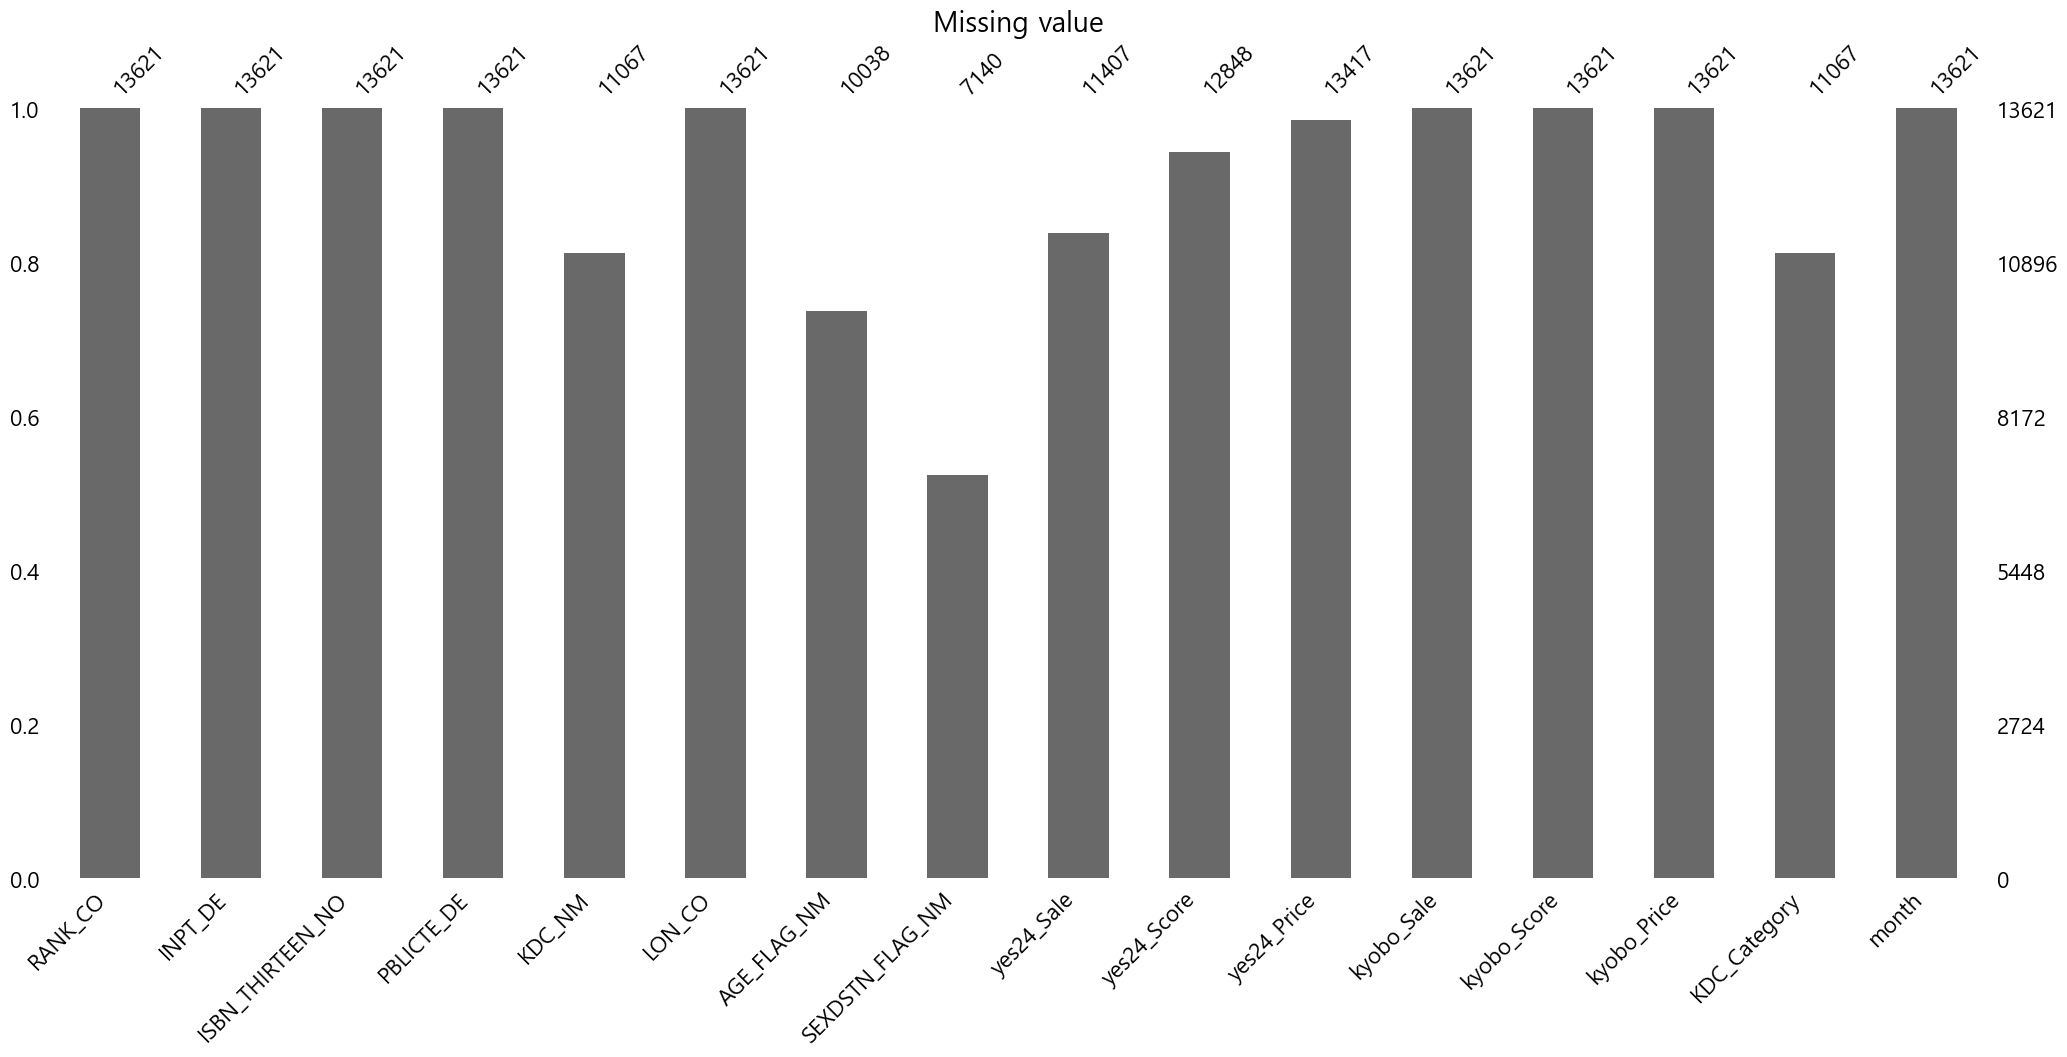

In [14]:
msno.bar(as_data)
plt.title("Missing value" , fontsize = 20)
print(f"Data size : {as_data.shape[0]}")

# 결측치 비율 계산
for feature in as_data:
    print(f"{feature} Missing Percentage : {round(as_data[feature].isna().sum() / as_data.shape[0] * 100 , 2)}%")

In [15]:
# yes24 결측치 처리

as_data['yes24_Sale'] = as_data['yes24_Sale'].str.replace(',' , '')
as_data['yes24_Sale'] = as_data['yes24_Sale'].fillna(-1).astype('int').replace({-1 : np.NaN})

as_data['yes24_Price'] = as_data['yes24_Price'].str.replace(',' , '')
as_data['yes24_Price'] = as_data['yes24_Price'].fillna(-1).astype('int').replace({-1 : np.NaN})

In [16]:
# 중앙값으로 변경

as_data['yes24_Sale'] = as_data['yes24_Sale'].fillna(as_data['yes24_Sale'].median())
as_data['yes24_Score'] = as_data['yes24_Score'].fillna(as_data['yes24_Score'].median())
as_data['yes24_Price'] = as_data['yes24_Price'].fillna(as_data['yes24_Price'].median())

In [17]:
# 카테고리의 na를 제거

as_data.dropna(subset = ['KDC_NM' , 'KDC_Category'] , inplace = True)

In [18]:
check = as_data['PBLICTE_DE'].value_counts().sort_values(ascending = False)
print(check)
as_data['PBLICTE_DE'] = as_data['PBLICTE_DE'].fillna('2020')

PBLICTE_DE
2020          2180
2019          1369
2021          1312
2018           998
2017           834
              ... 
2020[실은 20       1
1982, c197       1
2011-2016        1
0001             1
2001-2004        1
Name: count, Length: 122, dtype: int64


In [19]:
# 나이와 성별 데이터 결측값 처리

cols = ['AGE_FLAG_NM' , 'SEXDSTN_FLAG_NM'] # 해당 컬럼 처리 필요

as_data.drop(['INPT_DE'] , axis = 1 , inplace = True) # 연도 컬럼은 제거

In [20]:
as_data['AGE_FLAG_NM'] = as_data['AGE_FLAG_NM'].str.split('(').str[0]

In [21]:
# 범주화 작업

mapp = {
    '영유아': 1,
    '유아': 1,
    '초등': 2,
    '청소년': 3,
    '20대': 4,
    '30대': 5,
    '40대': 6,
    '50대': 7,
    '60대이상': 8
}

as_data['AGE_FLAG_NM'] = as_data['AGE_FLAG_NM'].map(mapp)

In [22]:
# 만약 그냥 삭제할 경우

test = as_data.copy()
print(f"삭제 전 후 : {test.shape[0]} -> {test.dropna().shape[0]}")

삭제 전 후 : 11067 -> 5198


In [23]:
mapp = {
    '남성' : 0 ,
    '여성' : 1
}

as_data['SEXDSTN_FLAG_NM'] = as_data['SEXDSTN_FLAG_NM'].map(mapp)

In [24]:
# 모델 기반 결측치 처리

cols = ['AGE_FLAG_NM' , 'SEXDSTN_FLAG_NM']
train_copy = as_data.copy(deep = True)
target_data = train_copy[cols]
train_copy.drop(cols , axis = 1 , inplace = True)

train_copy.drop(['PBLICTE_DE'] , axis = 1 , inplace = True)
train_copy = train_copy.astype({
    'KDC_NM' : 'float' ,
    'month' : 'int'
})

encoder = LabelEncoder()
train_copy['KDC_Category'] = encoder.fit_transform(train_copy['KDC_Category'])

# 스케일링

scaler = RobustScaler()
train_copy = scaler.fit_transform(train_copy)
train_copy = pd.DataFrame(train_copy , index = as_data.index , columns = as_data.drop(['AGE_FLAG_NM' , 'SEXDSTN_FLAG_NM' , 'PBLICTE_DE'] , axis = 1).columns)

In [25]:
# 나이 데이터 결측값 처리

temp = pd.concat([train_copy , target_data['AGE_FLAG_NM']] , axis = 1)

# 학습데이터 , 검증데이터 , 테스트 데이터 분리
train = temp[~(temp['AGE_FLAG_NM'].isna())]
test = temp[(temp['AGE_FLAG_NM'].isna())]

target = train['AGE_FLAG_NM'] # 학습용 종속변수
train.drop(['AGE_FLAG_NM'] , axis = 1 , inplace = True) # 학습용 독립변수

prediction_result = test['AGE_FLAG_NM'] # 예측한 값을 여기에 넣는다
test.drop(['AGE_FLAG_NM'] , axis = 1 , inplace = True) # 테스트 데이터

# 데이터 분리
trainX , validX , trainY , validY = train_test_split(train , target , test_size = 0.2 , random_state = 42)

In [26]:
# 모델 설정 및 모델 학습

model = RandomForestClassifier()

model.fit(trainX , trainY)

# 결정계수 출력

print(f"R2 Score \n{model.score(trainX , trainY)}\n{model.score(validX , validY)}")

R2 Score 
1.0
0.6746647847565279


In [27]:
# 예측 및 성능 측정

prediction = model.predict(validX)

print(classification_report(validY , prediction))

              precision    recall  f1-score   support

         1.0       0.70      0.89      0.78       379
         2.0       0.82      0.50      0.62        82
         3.0       0.63      0.48      0.54       198
         4.0       0.67      0.72      0.69       335
         5.0       0.73      0.12      0.21        64
         6.0       0.71      0.56      0.63        48
         7.0       0.63      0.67      0.65       311

    accuracy                           0.67      1417
   macro avg       0.70      0.56      0.59      1417
weighted avg       0.68      0.67      0.66      1417



In [28]:
# NA 예측

prediction_result = model.predict(test)

In [29]:
# 나이 NA 처리

as_data.loc[as_data['AGE_FLAG_NM'].isna() , 'AGE_FLAG_NM'] = prediction_result

In [30]:
# 성별 데이터 결측값 처리

temp = pd.concat([train_copy , target_data['SEXDSTN_FLAG_NM']] , axis = 1)

# 학습데이터 , 검증데이터 , 테스트 데이터 분리
train = temp[~(temp['SEXDSTN_FLAG_NM'].isna())]
test = temp[(temp['SEXDSTN_FLAG_NM'].isna())]

target = train['SEXDSTN_FLAG_NM'] # 학습용 종속변수
train.drop(['SEXDSTN_FLAG_NM'] , axis = 1 , inplace = True) # 학습용 독립변수

prediction_result = test['SEXDSTN_FLAG_NM'] # 예측한 값을 여기에 넣는다
test.drop(['SEXDSTN_FLAG_NM'] , axis = 1 , inplace = True) # 테스트 데이터

# 데이터 분리
trainX , validX , trainY , validY = train_test_split(train , target , test_size = 0.2 , random_state = 42)

In [31]:
# 모델 설정 및 모델 학습

model = RandomForestClassifier()

model.fit(trainX , trainY)

# 결정계수 출력

print(f"R2 Score \n{model.score(trainX , trainY)}\n{model.score(validX , validY)}")

R2 Score 
1.0
0.8136942675159236


In [32]:
# 예측 및 성능 측정

prediction = model.predict(validX)

print(classification_report(validY , prediction))

              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82       644
         1.0       0.83      0.77      0.80       612

    accuracy                           0.81      1256
   macro avg       0.82      0.81      0.81      1256
weighted avg       0.81      0.81      0.81      1256



In [33]:
# NA 예측

prediction_result = model.predict(test)

In [34]:
# 성별 NA 처리

as_data.loc[as_data['SEXDSTN_FLAG_NM'].isna() , 'SEXDSTN_FLAG_NM'] = prediction_result

In [35]:
# 중복 데이터 개수 확인

print(f"중복 데이터 삭제시 데이터 개수 변화 : {as_data.shape[0]} -> {as_data.shape[0] - as_data.duplicated().sum()}")

# 중복 데이터 삭제

final_data = as_data.drop_duplicates()

중복 데이터 삭제시 데이터 개수 변화 : 11067 -> 11067


In [36]:
final_data.shape

(11067, 15)

In [37]:
final_data.to_csv(path + 'final_data_drop_duplicates.csv')